In [2]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import nltk
import spacy
#from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import en_core_web_md
text_to_nlp = spacy.load('en_core_web_md')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

INVISIBLE_CHARS = re.compile(r'[\u200B\u200C\u200D\u200E\u200F\uFEFF\u00A0]')
URLS = re.compile(r'https?://\S+|www\.\S+')
EMOJIS = re.compile("["
                    u"\U0001F600-\U0001F64F"
                    u"\U0001F300-\U0001F5FF"
                    u"\U0001F680-\U0001F6FF"
                    u"\U0001F1E0-\U0001F1FF"
                    u"\U00002700-\U000027BF"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)

REMOVE_PUNCT_DIGITS = str.maketrans('', '', string.punctuation + string.digits)
CUSTOM_STOPWORDS = {
    '|', '=', '1', '5', '2018', 'usd', 'price', 'exchange',
    '€', '24', 'utc', 'en', 'high', 'low', 'volume'
}
BITCOIN_ALIASES = {'btc', 'bit', 'bitcoin', 'bitcoins', 'bit coin'}
OTHER_CRYPTO = {
    'eth', 'ethereum', 'xrp', 'bch', 'ltc', 'etc', 'ada', 'doge', 'shiba',
    'polkadot', 'dot', 'bnb', 'solana', 'trx', 'eos', 'neo', 'iota', 'monero',
    'dash', 'zec', 'vechain', 'theta', 'stellar', 'xlm', 'avax', 'algo',
    'matic', 'near', 'icp', 'aptos', 'apt', 'kaspa', 'kas'
}

import warnings
warnings.filterwarnings('ignore')

In [8]:
def clean_text(text):
    if not isinstance(text, str) or not text:
        return ''
    text = unicodedata.normalize('NFKC', text)
    text = INVISIBLE_CHARS.sub('', text)
    text = URLS.sub('', text)
    text = EMOJIS.sub('', text)
    text = text.lower()
    text = text.translate(REMOVE_PUNCT_DIGITS)
    tokens = text.split()

    has_bitcoin = False
    clean_tokens = []
    
    for token in tokens:
        if token in OTHER_CRYPTO or token in CUSTOM_STOPWORDS:
            continue
      
        if token in BITCOIN_ALIASES:
            if has_bitcoin:
                continue 
            else:
                #clean_tokens.append('bitcoin')
                has_bitcoin = True
        else:
            clean_tokens.append(token)

    return ' '.join(clean_tokens)

def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) and (token.lemma_ != '-PRON-') and (not token.is_punct):
            clean_tokens.append(token.lemma_)
    return clean_tokens

# Prices


In [26]:
df_SP2 = pd.read_csv("./Raw/SP500Price.csv")
df_BP2 = pd.read_csv("./Raw/BitcoinPrice2.csv")

df_BP2.drop(columns=['Vol.','Change %'], inplace=True)

df_SP2 = df_SP2.rename(columns={
    'Open': 'Open_S',
    'Close/Last': 'Close_S',
    'High': 'High_S',
    'Low': 'Low_S',
})

df_BP2 = df_BP2.rename(columns={
    'Price': 'Close_B',
    'Open': 'Open_B',
    'High': 'High_B',
    'Low': 'Low_B',
})

for col in ['Close_B', 'Open_B', 'High_B', 'Low_B']:
    df_BP2[col] = df_BP2[col].str.replace(',', '')
    df_BP2[col] = df_BP2[col].astype(float)  

df_SP2['Date'] = pd.to_datetime(df_SP2['Date'])
df_BP2['Date'] = pd.to_datetime(df_BP2['Date'])

merged_prices = pd.merge(df_SP2, df_BP2, on='Date')
merged_prices = merged_prices.sort_values('Date')

file_path = os.path.join('./Processed', 'combined_prices.csv')

merged_prices.to_csv(file_path, index=False)

merged_prices.tail

<bound method NDFrame.tail of           Date  Close_S   Open_S   High_S    Low_S  Close_B   Open_B   High_B  \
374 2022-01-03  4796.56  4778.14  4796.64  4758.17  46430.2  47293.9  47556.0   
373 2022-01-04  4793.54  4804.51  4818.62  4774.27  45837.3  46435.7  47505.4   
372 2022-01-05  4700.58  4787.99  4797.70  4699.44  43425.9  45833.1  47019.4   
371 2022-01-06  4696.05  4693.39  4725.01  4671.26  43097.5  43431.6  43772.3   
370 2022-01-07  4677.03  4697.66  4707.95  4662.74  41546.7  43097.9  43127.7   
..         ...      ...      ...      ...      ...      ...      ...      ...   
4   2023-06-26  4328.82  4344.84  4362.06  4328.08  30267.0  30466.3  30645.9   
3   2023-06-27  4378.41  4337.36  4384.42  4335.00  30689.1  30267.0  30993.7   
2   2023-06-28  4376.86  4367.48  4390.35  4360.22  30078.6  30691.9  30703.4   
1   2023-06-29  4396.44  4374.94  4398.39  4371.97  30445.7  30077.3  30823.1   
0   2023-06-30  4450.38  4422.44  4458.48  4422.44  30472.9  30445.7  31275.5  

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3838 - val_loss: 0.3811
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2805 - val_loss: 0.2300
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1431 - val_loss: 0.0473
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1066 - val_loss: 0.1047
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0882 - val_loss: 0.0699
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0828 - val_loss: 0.0621
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0786 - val_loss: 0.0763
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0774 - val_loss: 0.0555
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0797 - val_loss: 0.0648
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0767 - val_loss: 0.0651
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0754 - val_loss: 0.0589
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0745 - val_loss: 0.0709
Epoch 13/20


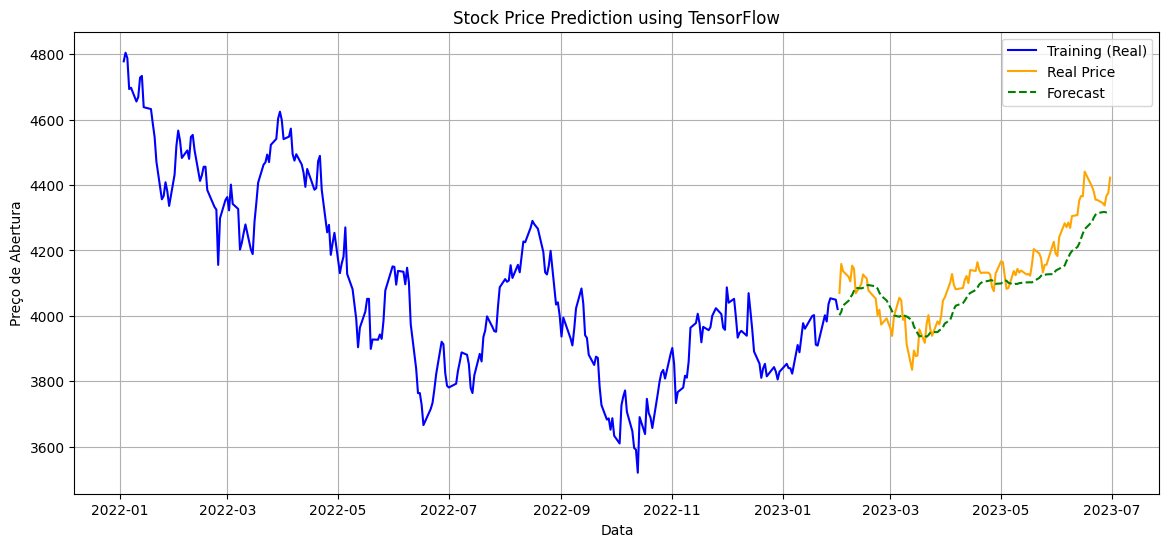

In [27]:
df = pd.read_csv('./Processed/combined_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'Open_S']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Open_S']])
df['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(df['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(df['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(df['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(df['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Stock Price Prediction using TensorFlow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Sentiment 

### Bitcoin

In [13]:
df_BS = pd.read_csv("./Raw/BitcoinSent.csv")

#clean dataframe
df_BS['date'] = pd.to_datetime(df_BS['date'], errors='coerce')
df_BS = df_BS[df_BS['date'].notna()]
df_BS = df_BS[df_BS['text'].notna()]
df_BS = df_BS[df_BS['text'].apply(lambda x: isinstance(x, str))]
df_BS = df_BS[df_BS['sentiment_label'].notna()]
df_BS = df_BS[df_BS['sentiment_label'].isin(['Positive', 'Negative', 'Neutral'])]
df_BS['sentiment_label'] = df_BS['sentiment_label'].map({'Positive': 1,'Neutral' : 0.5 , 'Negative': 0})

#sort in ascending date
df_BS = df_BS.sort_values(by='date', ascending=True)
df_BS = df_BS.reset_index(drop=True)

#testing
df_BS.tail

<bound method NDFrame.tail of          token       date  reply_count  like_count  retweet_count  \
0      bitcoin 2022-01-01           20         207             31   
1      bitcoin 2022-01-01           42        8102            271   
2      bitcoin 2022-01-01           80         730            109   
3      bitcoin 2022-01-01           38         718             64   
4      bitcoin 2022-01-01         1951        2212            560   
...        ...        ...          ...         ...            ...   
76792  bitcoin 2023-06-22          146         425             40   
76793  bitcoin 2023-06-22           98         537             44   
76794  bitcoin 2023-06-22           32         428             79   
76795  bitcoin 2023-06-22           97         435             34   
76796  bitcoin 2023-06-22           53       43524          46438   

       quote_count                                               text  \
0                3  Most people underestimate the impact #Bitcoin ..

In [8]:

'''
#FOR VISUALIZATION - OTHER FILE
mask = (df_BS['Date'] >= '2018-01-07') & (df_BS['Date'] <= '2018-02-06')

visu_words = df_BS.loc[mask]
visu_words.drop(columns='Sentiment', inplace=True)
visu_words = visu_words.reset_index(drop=True)

visu_words = visu_words.groupby('Date').apply(lambda x: x.sample(n=min(len(x), 800))).reset_index(drop=True)

visu_words['body'] = visu_words['body'].apply(clean_text)
visu_words['body'] = visu_words['body'].apply(tokenize)

visu_words.tail
visu_words.to_pickle('visu_words.pkl')
'''

In [9]:
#sample dataframe
sampled_BS = df_BS.groupby('Date').apply(lambda x: x.sample(n=min(len(x), 5))).reset_index(drop=True)

#clean every text
sampled_BS['body'] = sampled_BS['body'].apply(clean_text)

#apply tokenizer
sampled_BS['body'] = sampled_BS['body'].apply(tokenize)

#join dates and merge text
test = sampled_BS
test['body_str'] = test['body'].apply(lambda tokens: ' '.join(tokens))

test = test.groupby('Date').agg({
    'body': list,
    'body_str': lambda texts: ' '.join(texts),
    'Sentiment': 'mean'
}).reset_index()


file_path = os.path.join('./Processed', 'btc_nlp_test.csv')
test.to_csv(file_path, index=False)